# UniDoc: Multimodal Document Understanding Pipeline

PDF 문서를 세 가지 모달리티(Text, Image, Layout)의 embedding space로 변환하는 파이프라인 데모

## Pipeline Overview

```
PDF → Image → Layout Detection → OCR → Embedding (hᵀ, hᴵ, hᴸ)
```

## 1. Setup & Imports

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# UniDoc modules
from unidoc.detection import (
    LayoutDetector, 
    DetectedRegion, 
    RegionLabel,
    OCREngine,
    DetectionPipeline,
    RegionEmbedding,
    collate_embeddings
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

/workspace/UniDoc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.2.0+cu121
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


## 2. PDF → Image 변환

`pdf2image`를 사용하여 PDF 페이지를 이미지로 렌더링

PDF: Yvonne Strahovski.pdf
Page size: (1275, 1651)


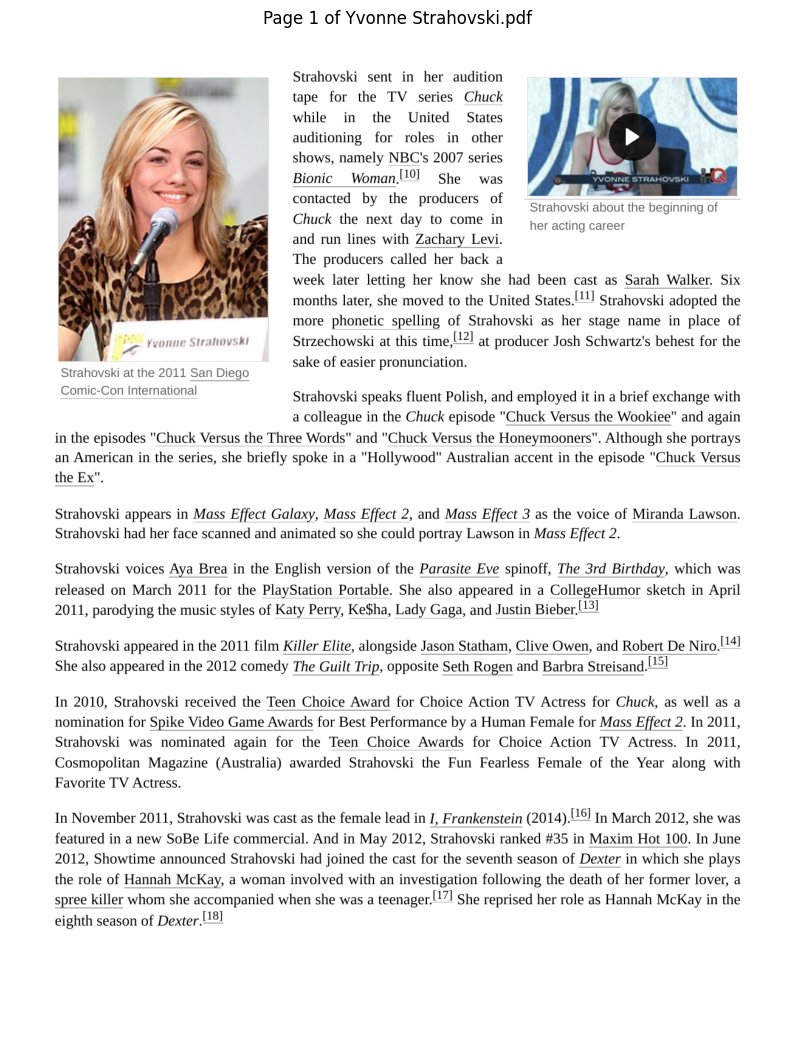

In [2]:
from pdf2image import convert_from_path

# 샘플 PDF 경로
pdf_path = Path("../data/feta_tab/docs/Yvonne Strahovski.pdf")

# PDF가 없으면 다른 파일 사용
if not pdf_path.exists():
    pdf_dir = Path("../data/feta_tab/docs")
    pdf_files = list(pdf_dir.glob("*.pdf"))
    if pdf_files:
        pdf_path = pdf_files[0]
        print(f"Using: {pdf_path.name}")
    else:
        raise FileNotFoundError("No PDF files found")

# PDF → 이미지 변환 (첫 페이지만)
page_images = convert_from_path(pdf_path, first_page=2, last_page=2, dpi=150)
page_image = page_images[0]

print(f"PDF: {pdf_path.name}")
print(f"Page size: {page_image.size}")

# 이미지 표시
plt.figure(figsize=(10, 14))
plt.imshow(page_image)
plt.title(f"Page 1 of {pdf_path.name}")
plt.axis('off')
plt.show()

## 3. Layout Detection

LayoutParser + EfficientDet (PubLayNet) 모델을 사용하여 문서 레이아웃 탐지

탐지 가능한 Region 타입:
- **Text**: 본문 텍스트
- **Title**: 제목
- **List**: 리스트
- **Table**: 표
- **Figure**: 그림/차트

In [3]:
# Layout Detector 초기화
layout_detector = LayoutDetector(
    model_name="efficientdet_d0",
    confidence_threshold=0.3
)

Loading LayoutParser model: efficientdet_d0
Model loaded successfully


In [4]:
# Layout Detection 실행
detected_regions = layout_detector.detect(page_image, extract_figures=True)

print(f"Detected {len(detected_regions)} regions:")
for region in detected_regions:
    print(f"  [{region.region_id}] {region.label.value:8s} - confidence: {region.confidence:.3f}, bbox: {tuple(int(x) for x in region.bbox)}")

Detected 4 regions:
  [0] Figure   - confidence: 0.627, bbox: (83, 77, 420, 540)
  [1] Text     - confidence: 0.553, bbox: (446, 66, 1208, 552)
  [2] Text     - confidence: 0.315, bbox: (79, 878, 1186, 982)
  [3] Text     - confidence: 0.351, bbox: (66, 1089, 1239, 1244)


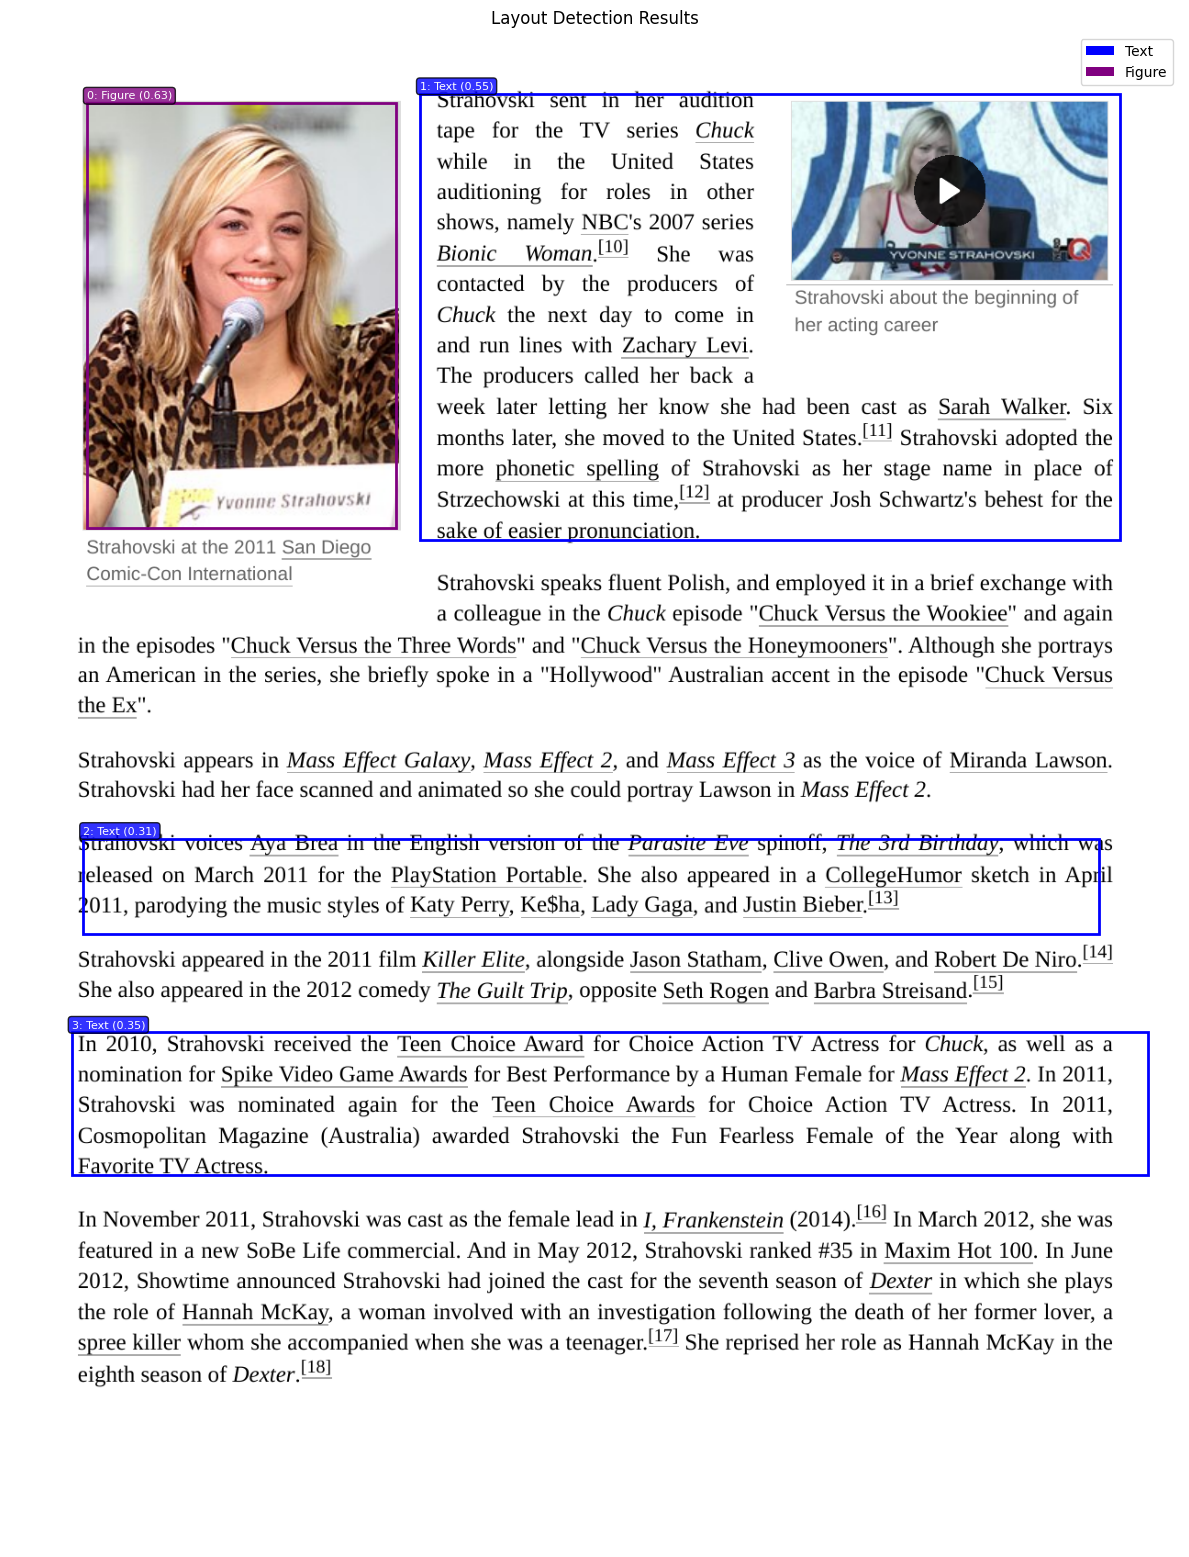

In [5]:
# Detection 결과 시각화
def visualize_regions(image, regions, title="Layout Detection Results"):
    """Detection 결과를 시각화"""
    # 색상 매핑
    colors = {
        RegionLabel.TEXT: 'blue',
        RegionLabel.TITLE: 'red',
        RegionLabel.LIST: 'green',
        RegionLabel.TABLE: 'orange',
        RegionLabel.FIGURE: 'purple',
        RegionLabel.UNKNOWN: 'gray'
    }
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))
    ax.imshow(image)
    
    for region in regions:
        x1, y1, x2, y2 = region.bbox
        color = colors.get(region.label, 'gray')
        
        # Bounding box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Label
        ax.text(
            x1, y1-5,
            f"{region.region_id}: {region.label.value} ({region.confidence:.2f})",
            fontsize=8,
            color='white',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8)
        )
    
    # Legend
    legend_elements = [
        patches.Patch(facecolor=color, label=label.value)
        for label, color in colors.items()
        if any(r.label == label for r in regions)
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_regions(page_image, detected_regions)

## 4. OCR (텍스트 추출)

EasyOCR을 사용하여 Text/Title/List 영역에서 텍스트 추출

In [6]:
# OCR Engine 초기화
ocr_engine = OCREngine(
    languages=['en'],
    gpu=torch.cuda.is_available(),
    confidence_threshold=0.3
)

Loading EasyOCR with languages: ['en']
EasyOCR loaded successfully


In [7]:
# 텍스트 영역에 OCR 적용
detected_regions = ocr_engine.process_regions(detected_regions, page_image)

print("OCR Results:")
print("=" * 80)
for region in detected_regions:
    print(f"\n[{region.region_id}] {region.label.value}")
    if region.text:
        # 텍스트가 길면 truncate
        text_preview = region.text[:200] + "..." if len(region.text) > 200 else region.text
        print(f"    Text: {text_preview}")
    else:
        print(f"    (No text - visual region)")

OCR Results:

[0] Figure
    (No text - visual region)

[1] Text
    Text: Strahovski sent in her audition tape for the TV series Chuck while in the United States auditioning for roles in other shows, namely NBC's 2007 series Bionic Woman [10] She was contacted by the produc...

[2] Text
    Text: voices Aya Brea 1n the Englsh version of the parasite Eve spinofl Tne gra Blrthday, which WZ eleased on March 2011 for the PlayStation Portable  She also appeared in CollegeHumor sketch in Apr 2011, p...

[3] Text
    Text: In 2010, Strahovski received the Teen Choice Award for Choice Action TV Actress for Chuck; as well as nomination for Spike Video Game Awards for Best Performance by a Human Female for Mass Effect 2. I...


## 5. Tokenization (Embedding 생성)

각 Region을 세 가지 모달리티 embedding으로 변환:

| Region Type | hᵀ (Text) | hᴵ (Image) | hᴸ (Layout) |
|-------------|:---------:|:----------:|:-----------:|
| Text        | ✅        | ❌         | ✅          |
| Title       | ✅        | ❌         | ✅          |
| List        | ✅        | ❌         | ✅          |
| Table       | ✅        | ✅         | ✅          |
| Figure      | ❌        | ✅         | ✅          |

### 5.1 Layout Embedding (LayoutLMv3)

LayoutLMv3의 pretrained encoder를 사용하여 문서 구조로 학습된 layout representation 추출

- **Pretrained**: 대규모 문서 데이터로 사전학습
- **2D Position Embedding**: bbox 좌표를 이해하는 학습된 표현
- **No Random MLP**: 기존 sinusoidal + random MLP 대신 pretrained weights 활용

In [8]:
from unidoc.tokenization import LayoutEmbedding

# Layout Embedding 초기화 (LayoutLMv3 기반)
# - freeze_embeddings=True: pretrained position embeddings 고정
# - use_projection=True: 768 -> 3584 차원 변환
print("Loading LayoutLMv3 position embeddings...")
layout_encoder = LayoutEmbedding(
    model_name="microsoft/layoutlmv3-base",
    hidden_size=3584,
    freeze_embeddings=True,
    use_projection=True
)
layout_encoder.eval()
print(f"LayoutLMv3 loaded! Embedding size: {layout_encoder.layoutlm_embedding_size} -> {layout_encoder.hidden_size}")

# 예시: 첫 번째 region의 layout embedding
region = detected_regions[0]
page_width, page_height = page_image.size

with torch.no_grad():
    h_layout = layout_encoder(
        bbox=region.bbox,
        page_width=page_width,
        page_height=page_height
    )

print(f"\nLayout Embedding for Region {region.region_id} ({region.label.value}):")
print(f"  BBox: {tuple(int(x) for x in region.bbox)}")
print(f"  Shape: {h_layout.shape}")
print(f"  Min: {h_layout.min().item():.4f}, Max: {h_layout.max().item():.4f}")
print(f"  Mean: {h_layout.mean().item():.4f}, Std: {h_layout.std().item():.4f}")

Loading LayoutLMv3 position embeddings...
LayoutLMv3 loaded! Embedding size: 768 -> 3584

Layout Embedding for Region 0 (Figure):
  BBox: (83, 77, 420, 540)
  Shape: torch.Size([3584])
  Min: -0.1700, Max: 3.6307
  Mean: 0.2805, Std: 0.5928


In [9]:
# 모든 region의 layout embedding 비교
print("Computing layout embeddings for all regions...")
print("=" * 70)

all_layout_embs = []
with torch.no_grad():
    for region in detected_regions:
        h_l = layout_encoder(
            bbox=region.bbox,
            page_width=page_width,
            page_height=page_height
        )
        all_layout_embs.append(h_l)
        
        # bbox를 0-1023 scale로 출력 (LayoutLMv3 position embedding 형식)
        norm_bbox = layout_encoder._normalize_bbox_to_1024(region.bbox, page_width, page_height)
        print(f"[{region.region_id}] {region.label.value:8s} | bbox(0-1023): {norm_bbox[:4]}")

# Stack all embeddings
h_layout_stack = torch.stack(all_layout_embs)
print(f"\nAll layout embeddings shape: {h_layout_stack.shape}")

# Region 간 유사도 계산
h_norm = h_layout_stack / h_layout_stack.norm(dim=1, keepdim=True)
similarity = torch.mm(h_norm, h_norm.t())

print("\nCosine Similarity Matrix (LayoutLMv3 embeddings):")
print("       ", end="")
for r in detected_regions:
    print(f"{r.label.value[:4]:>6s}", end="")
print()

for i, r1 in enumerate(detected_regions):
    print(f"[{r1.region_id}]{r1.label.value[:4]:>4s}", end="")
    for j, r2 in enumerate(detected_regions):
        print(f"{similarity[i,j].item():6.2f}", end="")
    print()

Computing layout embeddings for all regions...
[0] Figure   | bbox(0-1023): (66, 47, 337, 334)
[1] Text     | bbox(0-1023): (357, 41, 969, 342)
[2] Text     | bbox(0-1023): (63, 544, 951, 608)
[3] Text     | bbox(0-1023): (53, 675, 994, 771)

All layout embeddings shape: torch.Size([4, 3584])

Cosine Similarity Matrix (LayoutLMv3 embeddings):
         Figu  Text  Text  Text
[0]Figu  1.00  0.51  0.31  0.33
[1]Text  0.51  1.00  0.32  0.46
[2]Text  0.31  0.32  1.00  0.54
[3]Text  0.33  0.46  0.54  1.00


### 5.2 Text Embedding (Lite Mode)

실제 환경에서는 Qwen2-VL을 사용하지만, 데모에서는 Lite 모드 사용

In [10]:
from unidoc.tokenization import TextEmbeddingLite

# Text Embedding 초기화 (Lite 모드)
text_encoder = TextEmbeddingLite(hidden_size=3584)

# 텍스트가 있는 첫 번째 region 찾기
text_region = next((r for r in detected_regions if r.text), None)

if text_region:
    h_text = text_encoder.encode(text_region.text)
    
    print(f"Text Embedding for Region {text_region.region_id} ({text_region.label.value}):")
    print(f"  Text: {text_region.text[:100]}...")
    print(f"  Shape: {h_text.shape}")
    print(f"  Min: {h_text.min().item():.4f}, Max: {h_text.max().item():.4f}")
else:
    print("No text regions found")

Text Embedding for Region 1 (Text):
  Text: Strahovski sent in her audition tape for the TV series Chuck while in the United States auditioning ...
  Shape: torch.Size([3584])
  Min: -1.4618, Max: 1.3518


### 5.3 Visual Embedding (Lite Mode)

Figure/Table 영역의 이미지를 embedding으로 변환

Visual Embedding for Region 0 (Figure):
  Image size: (337, 463)
  Shape: torch.Size([3584])
  Min: -1.6423, Max: 1.3677


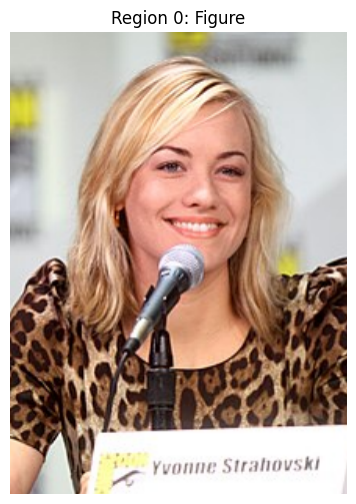

In [11]:
from unidoc.tokenization import VisualEmbeddingLite

# Visual Embedding 초기화 (Lite 모드)
visual_encoder = VisualEmbeddingLite(hidden_size=3584)

# Figure 또는 Table region 찾기
visual_region = next(
    (r for r in detected_regions if r.label in [RegionLabel.FIGURE, RegionLabel.TABLE]),
    None
)

if visual_region and visual_region.image:
    h_image = visual_encoder.encode(visual_region.image)
    
    print(f"Visual Embedding for Region {visual_region.region_id} ({visual_region.label.value}):")
    print(f"  Image size: {visual_region.image.size}")
    print(f"  Shape: {h_image.shape}")
    print(f"  Min: {h_image.min().item():.4f}, Max: {h_image.max().item():.4f}")
    
    # 이미지 표시
    plt.figure(figsize=(6, 6))
    plt.imshow(visual_region.image)
    plt.title(f"Region {visual_region.region_id}: {visual_region.label.value}")
    plt.axis('off')
    plt.show()
else:
    print("No visual regions (Figure/Table) found")

## 6. Full Pipeline (통합 파이프라인)

`DetectionPipeline` 클래스를 사용하여 전체 과정을 한 번에 실행

In [12]:
# Full Pipeline 초기화 (Lite 모드)
pipeline = DetectionPipeline(
    use_lite=True,              # Qwen2-VL 없이 테스트용
    ocr_languages=['en'],
    detection_confidence=0.3
)

Initializing Layout Detector...
Loading LayoutParser model: efficientdet_d0
Model loaded successfully
Initializing OCR Engine...
Loading EasyOCR with languages: ['en']
EasyOCR loaded successfully
Initializing Encoders...
Pipeline initialized!


In [13]:
# PDF 처리
all_embeddings = pipeline.process_pdf(pdf_path, pages=[1])
embeddings = all_embeddings[0]  # 첫 페이지

print(f"Processed {len(embeddings)} regions from page 1")
print("=" * 80)

Processed 8 regions from page 1


In [14]:
# 결과 출력
for emb in embeddings:
    print(f"\n[{emb.region_id}] {emb.label.value} (conf: {emb.confidence:.3f})")
    print(f"    h_text:   {emb.h_text.shape if emb.has_text else 'None'}")
    print(f"    h_image:  {emb.h_image.shape if emb.has_image else 'None'}")
    print(f"    h_layout: {emb.h_layout.shape}")
    if emb.text:
        text_preview = emb.text[:80] + "..." if len(emb.text) > 80 else emb.text
        print(f"    text: {text_preview}")


[0] Text (conf: 0.944)
    h_text:   torch.Size([3584])
    h_image:  None
    h_layout: torch.Size([3584])
    text: Yvonne  Jaqueline   Strzechowskil1][2] (born 30   July 1982), known professional...

[1] Figure (conf: 0.309)
    h_text:   None
    h_image:  torch.Size([3584])
    h_layout: torch.Size([3584])

[2] Figure (conf: 0.640)
    h_text:   None
    h_image:  torch.Size([3584])
    h_layout: torch.Size([3584])

[3] Text (conf: 0.633)
    h_text:   torch.Size([3584])
    h_image:  None
    h_layout: torch.Size([3584])
    text: Strahovski's other notable works include Lego: The Adventures of Clutch Powers (...

[4] Text (conf: 0.958)
    h_text:   torch.Size([3584])
    h_image:  None
    h_layout: torch.Size([3584])
    text: Strahovski was born in Werrington Downs, Sydney, New South Wales,[3] the daughte...

[5] Title (conf: 0.578)
    h_text:   torch.Size([3584])
    h_image:  None
    h_layout: torch.Size([3584])
    text: Early life

[6] Text (conf: 0.383)
    h_text:   

## 7. Batch Processing

`collate_embeddings`를 사용하여 여러 region을 배치 텐서로 변환

In [15]:
# Batch로 변환
batch = collate_embeddings(embeddings)

print("Batch Tensors:")
print(f"  h_layout: {batch['h_layout'].shape}")
print(f"  h_text:   {batch['h_text'].shape if batch['h_text'] is not None else 'None'}")
print(f"  h_image:  {batch['h_image'].shape if batch['h_image'] is not None else 'None'}")
print(f"\nMasks:")
print(f"  text_mask:  {batch['text_mask']} ({batch['text_mask'].sum().item()} regions with text)")
print(f"  image_mask: {batch['image_mask']} ({batch['image_mask'].sum().item()} regions with image)")
print(f"\nIndices:")
print(f"  text_indices:  {batch['text_indices']}")
print(f"  image_indices: {batch['image_indices']}")
print(f"\nTotal regions: {batch['num_regions']}")

Batch Tensors:
  h_layout: torch.Size([8, 3584])
  h_text:   torch.Size([6, 3584])
  h_image:  torch.Size([2, 3584])

Masks:
  text_mask:  tensor([ True, False, False,  True,  True,  True,  True,  True],
       device='cuda:0') (6 regions with text)
  image_mask: tensor([False,  True,  True, False, False, False, False, False],
       device='cuda:0') (2 regions with image)

Indices:
  text_indices:  [0, 3, 4, 5, 6, 7]
  image_indices: [1, 2]

Total regions: 8


## 8. Embedding 분석

In [16]:
# Layout embedding 통계
h_layout_all = batch['h_layout']

print("Layout Embedding Statistics:")
print(f"  Shape: {h_layout_all.shape}")
print(f"  Mean: {h_layout_all.mean().item():.4f}")
print(f"  Std: {h_layout_all.std().item():.4f}")
print(f"  Min: {h_layout_all.min().item():.4f}")
print(f"  Max: {h_layout_all.max().item():.4f}")

Layout Embedding Statistics:
  Shape: torch.Size([8, 3584])
  Mean: 0.2814
  Std: 0.5897
  Min: -0.1700
  Max: 3.7003


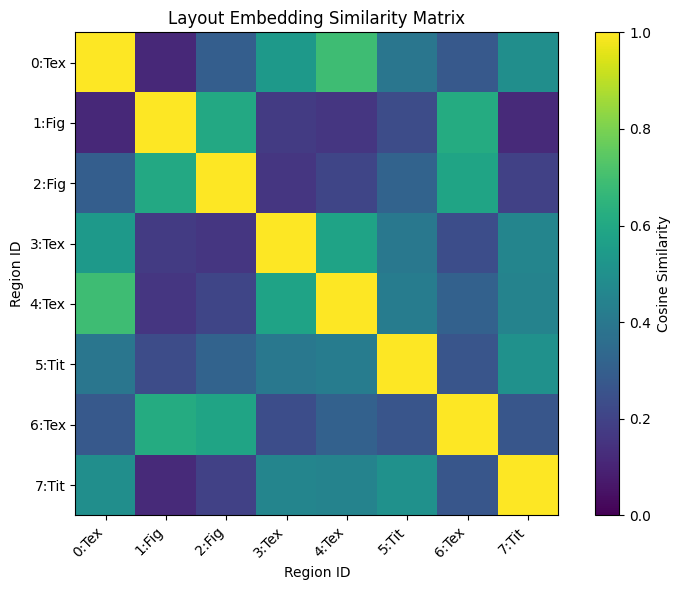

In [17]:
# Region 간 Layout embedding 유사도
if len(embeddings) > 1:
    # Cosine similarity matrix
    h_layout_norm = h_layout_all / h_layout_all.norm(dim=1, keepdim=True)
    similarity_matrix = torch.mm(h_layout_norm, h_layout_norm.t())
    
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix.detach().cpu().numpy(), cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Cosine Similarity')
    plt.xlabel('Region ID')
    plt.ylabel('Region ID')
    plt.title('Layout Embedding Similarity Matrix')
    
    # Region labels as tick labels
    labels = [f"{e.region_id}:{e.label.value[:3]}" for e in embeddings]
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(range(len(labels)), labels)
    
    plt.tight_layout()
    plt.show()

## 9. Embedding Space 시각화

PCA와 t-SNE를 사용하여 세 모달리티(Text, Image, Layout) embedding space를 2D로 시각화

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 여러 PDF에서 embedding 수집 (더 많은 데이터로 시각화)
pdf_dir = Path("../data/feta_tab/docs")
pdf_files = list(pdf_dir.glob("*.pdf"))[:5]  # 5개 PDF만 사용

all_h_text = []
all_h_image = []
all_h_layout = []
all_labels = []
all_region_types = []

print("Collecting embeddings from multiple PDFs...")
for pdf_file in pdf_files:
    try:
        page_embs = pipeline.process_pdf(pdf_file, pages=[1])[0]
        for emb in page_embs:
            all_h_layout.append(emb.h_layout.detach().cpu())
            all_labels.append(emb.label.value)
            all_region_types.append(emb.label)
            
            if emb.has_text:
                all_h_text.append(emb.h_text.detach().cpu())
            if emb.has_image:
                all_h_image.append(emb.h_image.detach().cpu())
        print(f"  {pdf_file.name}: {len(page_embs)} regions")
    except Exception as e:
        print(f"  {pdf_file.name}: Error - {e}")

print(f"\nTotal: {len(all_h_layout)} layout, {len(all_h_text)} text, {len(all_h_image)} image embeddings")

  Yvonne Strahovski.pdf: 8 regions
  List of German football champions.pdf: 5 regions
  Deuterocanonical books.pdf: 3 regions
  Athletics at the 2016 Summer Olympics – Men's 400 metres.pdf: 8 regions
  Chuck (TV series).pdf: 7 regions

Total: 31 layout, 24 text, 7 image embeddings


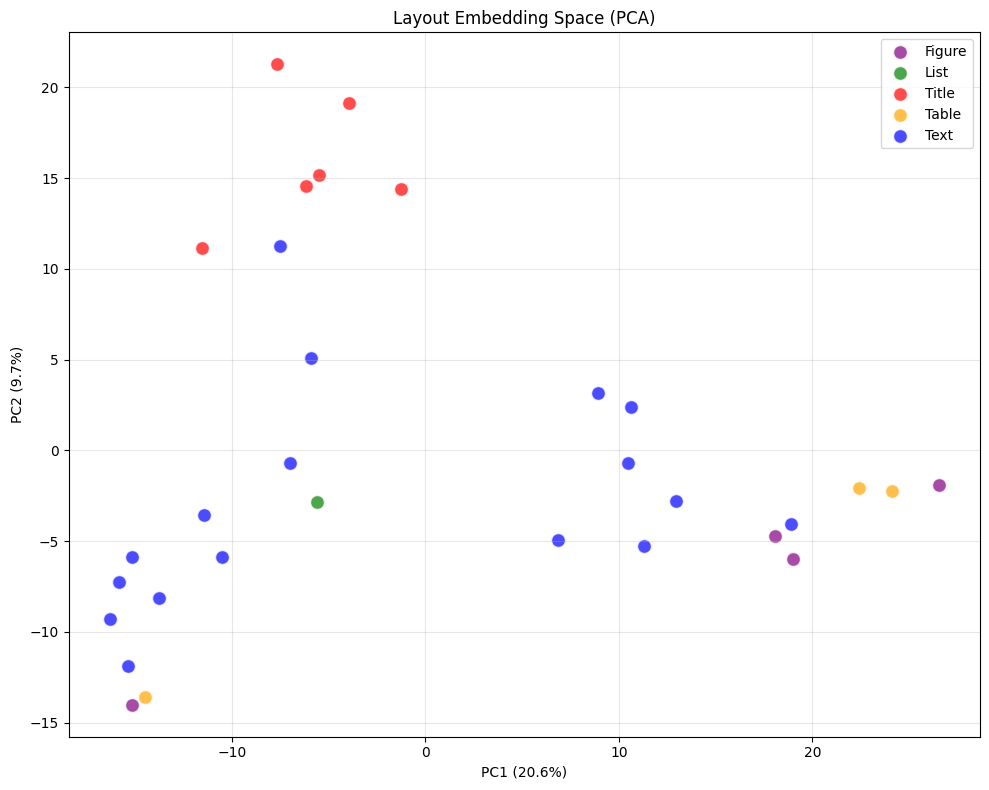

PCA explained variance: 30.3%


In [19]:
# Layout Embedding Space 시각화 (PCA)
h_layout_stack = torch.stack(all_h_layout).numpy()

# PCA로 2D 축소
pca = PCA(n_components=2)
layout_2d = pca.fit_transform(h_layout_stack)

# Region type별 색상
color_map = {
    'Text': 'blue',
    'Title': 'red',
    'List': 'green',
    'Table': 'orange',
    'Figure': 'purple',
    'Unknown': 'gray'
}
colors = [color_map.get(label, 'gray') for label in all_labels]

plt.figure(figsize=(10, 8))
for label in set(all_labels):
    mask = [l == label for l in all_labels]
    pts = layout_2d[mask]
    plt.scatter(pts[:, 0], pts[:, 1], c=color_map.get(label, 'gray'), 
                label=label, alpha=0.7, s=100, edgecolors='white')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Layout Embedding Space (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA explained variance: {sum(pca.explained_variance_ratio_)*100:.1f}%")

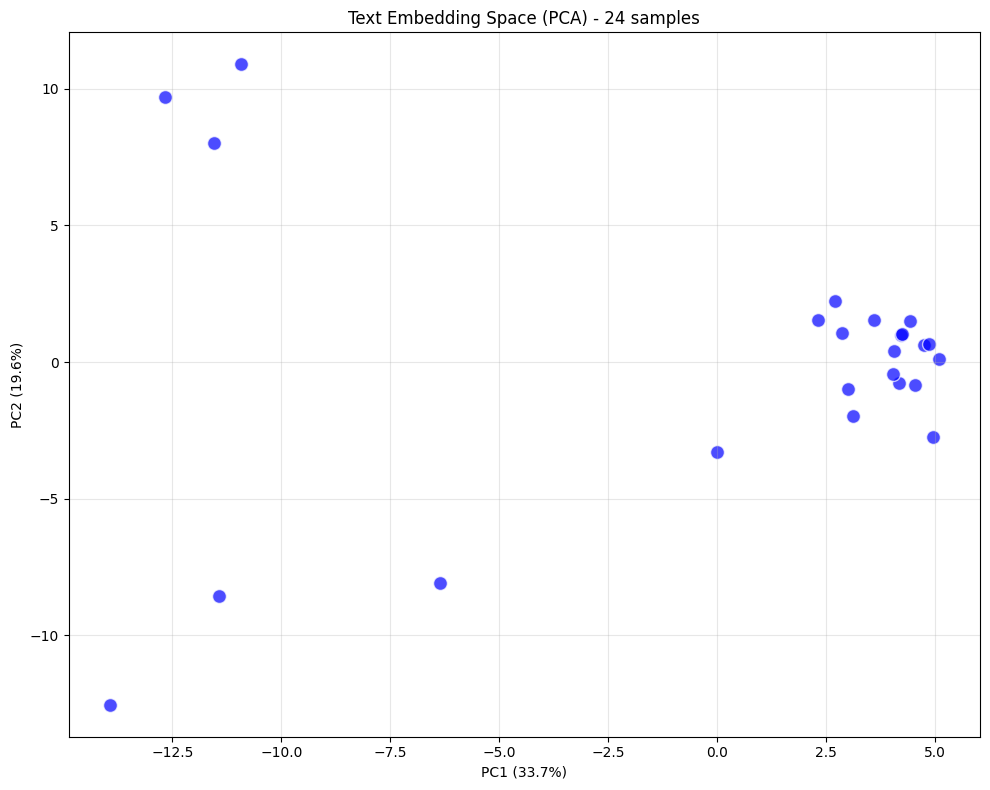

Text PCA explained variance: 53.3%


In [20]:
# Text Embedding Space 시각화 (PCA)
if len(all_h_text) > 2:
    h_text_stack = torch.stack(all_h_text).numpy()
    
    pca_text = PCA(n_components=2)
    text_2d = pca_text.fit_transform(h_text_stack)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(text_2d[:, 0], text_2d[:, 1], c='blue', alpha=0.7, s=100, edgecolors='white')
    
    plt.xlabel(f'PC1 ({pca_text.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_text.explained_variance_ratio_[1]*100:.1f}%)')
    plt.title(f'Text Embedding Space (PCA) - {len(all_h_text)} samples')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Text PCA explained variance: {sum(pca_text.explained_variance_ratio_)*100:.1f}%")
else:
    print("Not enough text embeddings for visualization")

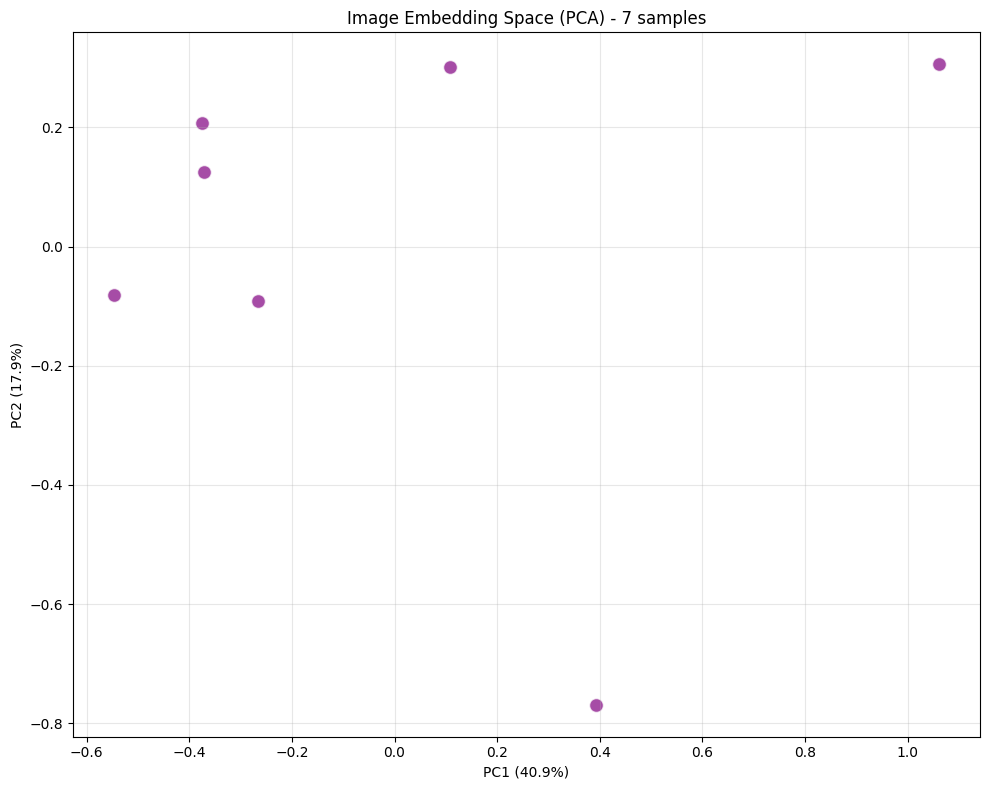

Image PCA explained variance: 58.7%


In [21]:
# Image Embedding Space 시각화 (PCA)
if len(all_h_image) > 2:
    h_image_stack = torch.stack(all_h_image).numpy()
    
    pca_image = PCA(n_components=2)
    image_2d = pca_image.fit_transform(h_image_stack)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(image_2d[:, 0], image_2d[:, 1], c='purple', alpha=0.7, s=100, edgecolors='white')
    
    plt.xlabel(f'PC1 ({pca_image.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_image.explained_variance_ratio_[1]*100:.1f}%)')
    plt.title(f'Image Embedding Space (PCA) - {len(all_h_image)} samples')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Image PCA explained variance: {sum(pca_image.explained_variance_ratio_)*100:.1f}%")
else:
    print(f"Not enough image embeddings for visualization ({len(all_h_image)} samples)")

In [22]:
# 세 모달리티 Embedding을 하나의 공간에서 비교 (t-SNE)
# 모든 embedding을 합쳐서 시각화

all_embeddings_combined = []
modality_labels = []
region_type_labels = []

# Layout embeddings
for i, h in enumerate(all_h_layout):
    all_embeddings_combined.append(h)
    modality_labels.append('Layout')
    region_type_labels.append(all_labels[i])

# Text embeddings (text가 있는 region만)
text_idx = 0
for i, label in enumerate(all_labels):
    if all_region_types[i] not in [RegionLabel.FIGURE]:  # Figure가 아니면 text가 있을 수 있음
        if text_idx < len(all_h_text):
            all_embeddings_combined.append(all_h_text[text_idx])
            modality_labels.append('Text')
            region_type_labels.append(label)
            text_idx += 1

# Image embeddings
for h in all_h_image:
    all_embeddings_combined.append(h)
    modality_labels.append('Image')
    region_type_labels.append('Figure')

combined_stack = torch.stack(all_embeddings_combined).numpy()
print(f"Combined embeddings: {combined_stack.shape}")

Combined embeddings: (62, 3584)


Running t-SNE (this may take a moment)...


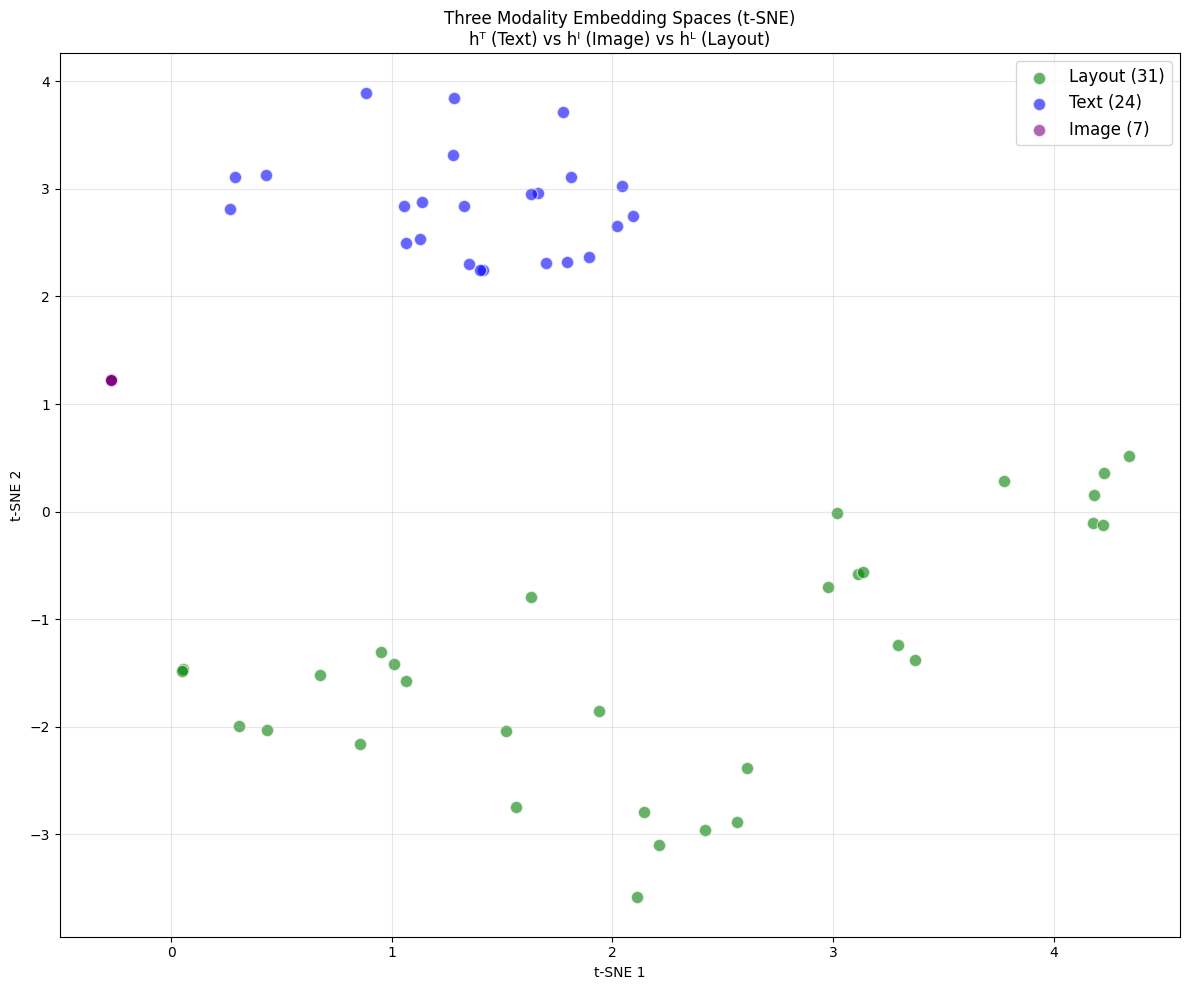

In [23]:
# t-SNE로 세 모달리티 시각화
print("Running t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, perplexity=min(30, len(combined_stack)-1), random_state=42, max_iter=1000)
combined_2d = tsne.fit_transform(combined_stack)

# 모달리티별 색상
modality_colors = {
    'Layout': 'green',
    'Text': 'blue', 
    'Image': 'purple'
}

plt.figure(figsize=(12, 10))

for modality in ['Layout', 'Text', 'Image']:
    mask = [m == modality for m in modality_labels]
    if sum(mask) > 0:
        pts = combined_2d[mask]
        plt.scatter(pts[:, 0], pts[:, 1], 
                   c=modality_colors[modality], 
                   label=f'{modality} ({sum(mask)})',
                   alpha=0.6, s=80, edgecolors='white')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Three Modality Embedding Spaces (t-SNE)\nhᵀ (Text) vs hᴵ (Image) vs hᴸ (Layout)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

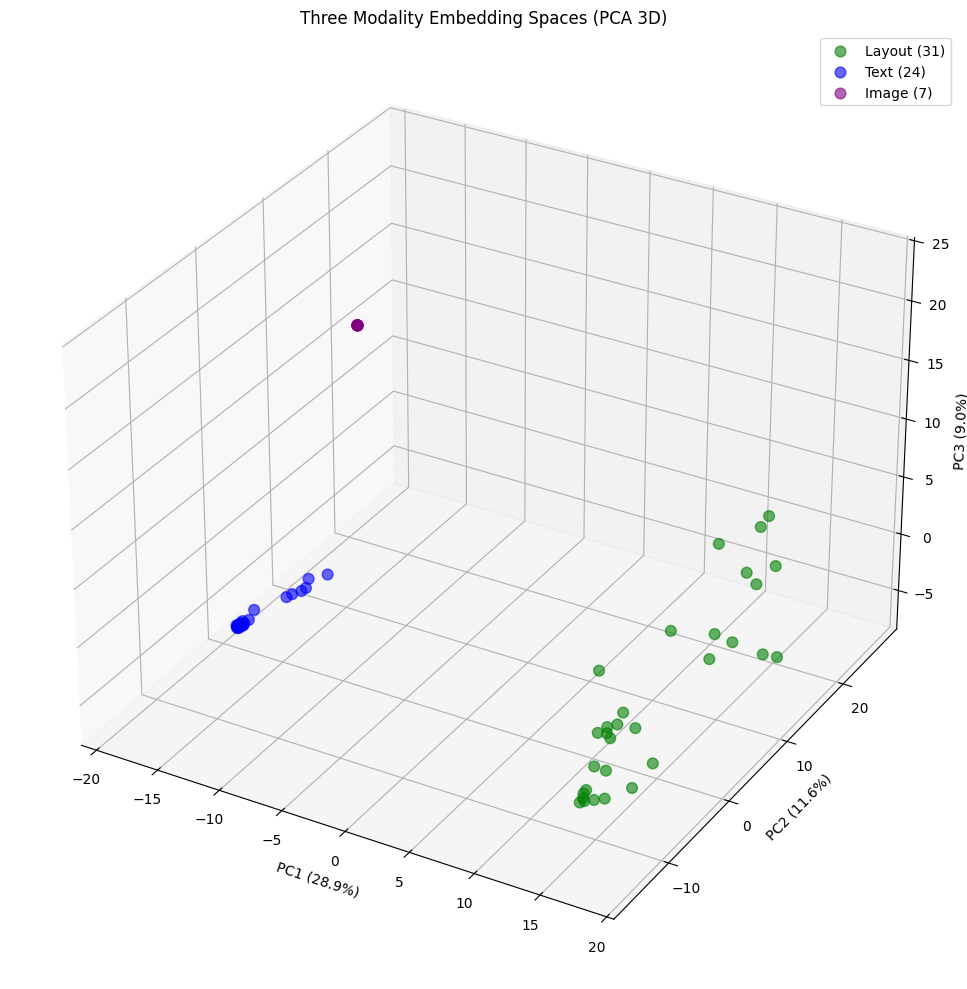

3D PCA explained variance: 49.5%


In [24]:
# 3D 시각화 (선택사항)
from mpl_toolkits.mplot3d import Axes3D

# PCA로 3D 축소
pca_3d = PCA(n_components=3)
combined_3d = pca_3d.fit_transform(combined_stack)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for modality in ['Layout', 'Text', 'Image']:
    mask = [m == modality for m in modality_labels]
    if sum(mask) > 0:
        pts = combined_3d[mask]
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                  c=modality_colors[modality],
                  label=f'{modality} ({sum(mask)})',
                  alpha=0.6, s=60)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('Three Modality Embedding Spaces (PCA 3D)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"3D PCA explained variance: {sum(pca_3d.explained_variance_ratio_)*100:.1f}%")

### 시각화 해석

**현재 상태 (Alignment 전)**:
- 세 모달리티(Text, Image, Layout)가 **서로 다른 공간**에 분포
- 각 encoder가 독립적으로 학습되지 않았으므로 구조가 없음 (Lite 모드는 random projection)

**목표 상태 (Alignment 후)**:
- 같은 region의 (hᵀ, hᴵ, hᴸ)가 **가까운 위치**에 매핑
- Figure와 그 Caption의 embedding이 유사한 위치
- Cross-modal retrieval이 가능해짐

In [25]:
# 여러 페이지가 있는 PDF 찾기
from pdf2image import pdfinfo_from_path

pdf_dir = Path("../data/feta_tab/docs")
multi_page_pdf = None

for pdf_file in pdf_dir.glob("*.pdf"):
    try:
        info = pdfinfo_from_path(pdf_file)
        if info.get('Pages', 0) > 1:
            multi_page_pdf = pdf_file
            print(f"Found multi-page PDF: {pdf_file.name} ({info['Pages']} pages)")
            break
    except:
        continue

if multi_page_pdf is None:
    print("No multi-page PDF found, using single page PDF")
    multi_page_pdf = pdf_path

Found multi-page PDF: Yvonne Strahovski.pdf (8 pages)


## 10. Summary

### 구현된 기능

1. **PDF → Image 변환**: `pdf2image`
2. **Layout Detection**: LayoutParser + EfficientDet (PubLayNet)
3. **OCR**: EasyOCR
4. **Text Embedding**: hᵀ → (3584,) - Lite mode (실제: Qwen2-VL)
5. **Visual Embedding**: hᴵ → (3584,) - Lite mode (실제: Qwen2-VL)
6. **Layout Embedding**: hᴸ → (3584,) - **LayoutLMv3 pretrained encoder**

### Layout Embedding 변경사항

| 항목 | 이전 (Sinusoidal + MLP) | 현재 (LayoutLMv3) |
|------|------------------------|-------------------|
| **Encoder** | Random MLP | Pretrained Transformer |
| **Position** | Sinusoidal encoding | 학습된 2D position embedding |
| **Knowledge** | 없음 | 문서 구조로 pretrained |
| **Learnable** | 전체 (1088→3584) | Projection만 (768→3584) |

### 다음 단계 (TODO)

- [ ] Absolute Semantic Space (Z) 구현
- [ ] Modality-specific projectors (A_T, A_I, A_L)
- [ ] Cross-modal alignment loss
- [ ] Qwen2-VL LLM 연결
- [ ] Training pipeline
- [ ] Evaluation on benchmarks

## 10. Summary

### 구현된 기능

1. **PDF → Image 변환**: `pdf2image`
2. **Layout Detection**: LayoutParser + EfficientDet (PubLayNet)
3. **OCR**: EasyOCR
4. **Text Embedding**: hᵀ → (3584,)
5. **Visual Embedding**: hᴵ → (3584,)
6. **Layout Embedding**: hᴸ → (3584,)

### 다음 단계 (TODO)

- [ ] Absolute Semantic Space (Z) 구현
- [ ] Modality-specific projectors (A_T, A_I, A_L)
- [ ] Cross-modal alignment loss
- [ ] Qwen2-VL LLM 연결
- [ ] Training pipeline
- [ ] Evaluation on benchmarks

In [26]:
print("Pipeline demo completed!")

Pipeline demo completed!
